In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

dataDir = Path('/scratch/guenther/MCParticleData')
file = 'bsphiphi500.h5'
zReference = 8520.
zMagnetParams = [5212.38, 406.609, -1102.35, -498.039]
xParams = [18.6195, -5.55793]
xLayers = [0,3,4,7,8,11]
uvLayers = [1,2,5,6,9,10]

with pd.HDFStore(dataDir/file, mode='r') as eventData:
    tmp = []
    # event loop
    for iEvent in range(0, 500):
        hits = eventData[str(iEvent)]
        tmp.append(hits.copy())
    allHits = pd.concat(tmp, ignore_index=True)

# Hough Histogram Studies
## Occupancy of the Detector
* data contains all x hits of 500 events in the range [-3000,3000]mm
* the first plot shows the coarse distribution of these hits along x
* the occupancy is higher in the central region than at the edges as expected

## Hough Histogram Binning
* the idea is to adjust the histogram's bin width along x such that every bin contains the same number of hits on average
* two approaches have been tested, one of which is shown below
1. in a **first attempt**, I fitted the (right) flank of the occupancy distribution with a 5th order polynomial to describe the occupancy for most of the range
    - to find regions of equal content, i.e. the desired bins, the culumative distribution must be calculated from which the quantiles (i.e. 500 quantiles for 500 bins) can (in theory) be calculated by $x_{Q}=F^{-1}(p)$ where $p$ is the "probability" given by $i_{bin}/N_{Bins}$
    - for polynomials of order higher than 3 this is, however, not analytically doable
    - other functions might be possible, but since there is an easier approach, I didn't look further into this
2. the **second approach** numerically calculates the quantiles for the full occupancy distribution using `pandas.qcut` function
    - this function directly gives the bin edges containing an equal amount of x hits
    - the bin edges are then enumerated and this enumeration is plotted against the edges, which is shown for different number of bins below
    - the resulting distribution is fitted with $f(x)=p_0+\frac{p_1\cdot x}{1+|p_2\cdot x|}$, which is chosen because it's computionally faster than e.g. a Sigmoid
    - the fitted function gives a direct mapping $x\to i_{Bin}$ when downcasted to integer values
    - the resulting minimal and maximal width of the bins is shown in the table and the last plot below for different total numbers of bins
    - 1000 bins have minimal bin width of 1.625mm which is of the order of the Hough Projection's resolution for high momentum tracks
    - the parameters for this scenario are $p_0=505.675291$, $p_1=0.453316164$ and $p_2=5.57027462\times 10^{-4}$
    - to avoid negative bin numbers arising from the imperfection of the parametrisation, the parameter $p_0$ can be shifted by +2.5 for 1000 bins
    - also because of the imperfection of the parametrisation, the real number of bins later on will be slightly higher, which is also shown in the table
    - the inverse. i.e. the mapping $i_{bin}\to x$ is $x=\frac{p_0-i_{Bin}}{p_0\cdot p_2-p_1-p_2\cdot i_{Bin}}$ for $i<p_0$ and $x=\frac{p_0+i_{Bin}}{p_0\cdot p_2+p_1-p_2\cdot i_{Bin}}$ else

BINS=600
shift=1.1
[ 3.03414161e+02  2.71945159e-01 -5.56801117e-04]
at -3000 = 0
at 3000 = 610
at -3000 = -0.9960452190164233
at 3000 = 610.0243669660781

BINS=700
shift=1.5
[ 3.53980141e+02  3.17291325e-01 -5.56893995e-04]
at -3000 = 0
at 3000 = 711
at -3000 = -0.9359283090630584
at 3000 = 711.8962100461829

BINS=800
shift=1.8
[ 4.04541076e+02  3.62631197e-01 -5.56941658e-04]
at -3000 = 0
at 3000 = 813
at -3000 = -0.9838529169481944
at 3000 = 813.6660040895719

BINS=900
shift=2.2
[4.55109246e+02 4.07977502e-01 5.56998216e-04]
at -3000 = 0
at 3000 = 915
at -3000 = -0.9217380096175134
at 3000 = 915.5402300772885

BINS=1000
shift=5.5
[5.05675291e+02 4.53316164e-01 5.57027462e-04]
at -3000 = 2
at 3000 = 1020
at -3000 = 2.037684447748063
at 3000 = 1020.3128978501425

BINS=1100
shift=4.9
[5.56237804e+02 4.98644231e-01 5.57020439e-04]
at -3000 = 1
at 3000 = 1121
at -3000 = 1.0860058517370135
at 3000 = 1121.1896027202529

BINS=1200
shift=3.2
[6.06805431e+02 5.43977948e-01 5.57024839e-04]
at 

NBINS  nBinsReal  minBinWidth  maxBinWidth
0    600        610        2.750    72.399902
1    700        712        2.375    61.944386
2    800        813        2.000    54.544922
3    900        916        1.750    49.346866
4   1000       1017        1.625    44.815297
5   1100       1119        1.375    40.286656
6   1200       1221        1.375    36.824951
7   1300       1323        1.250    34.324951
8   1400       1424        1.125    31.924148
9   1500       1527        1.000    30.625244

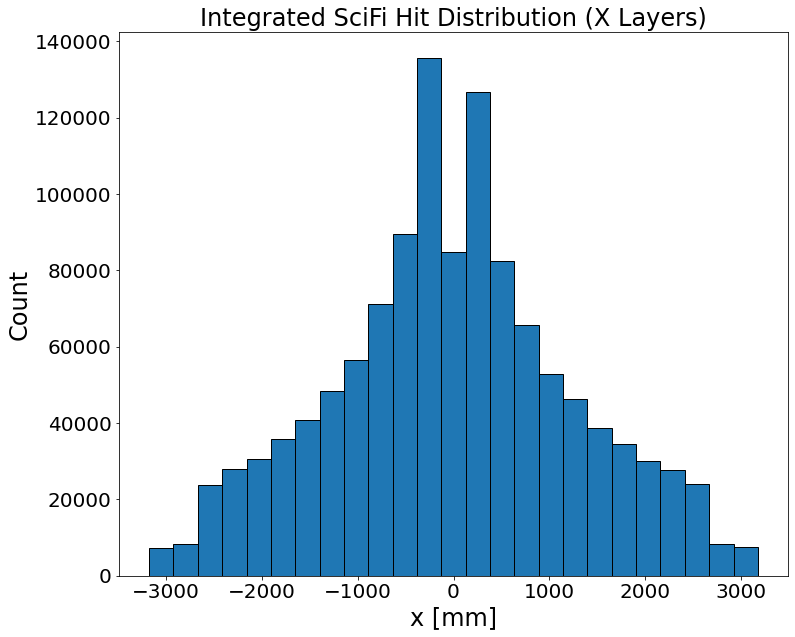

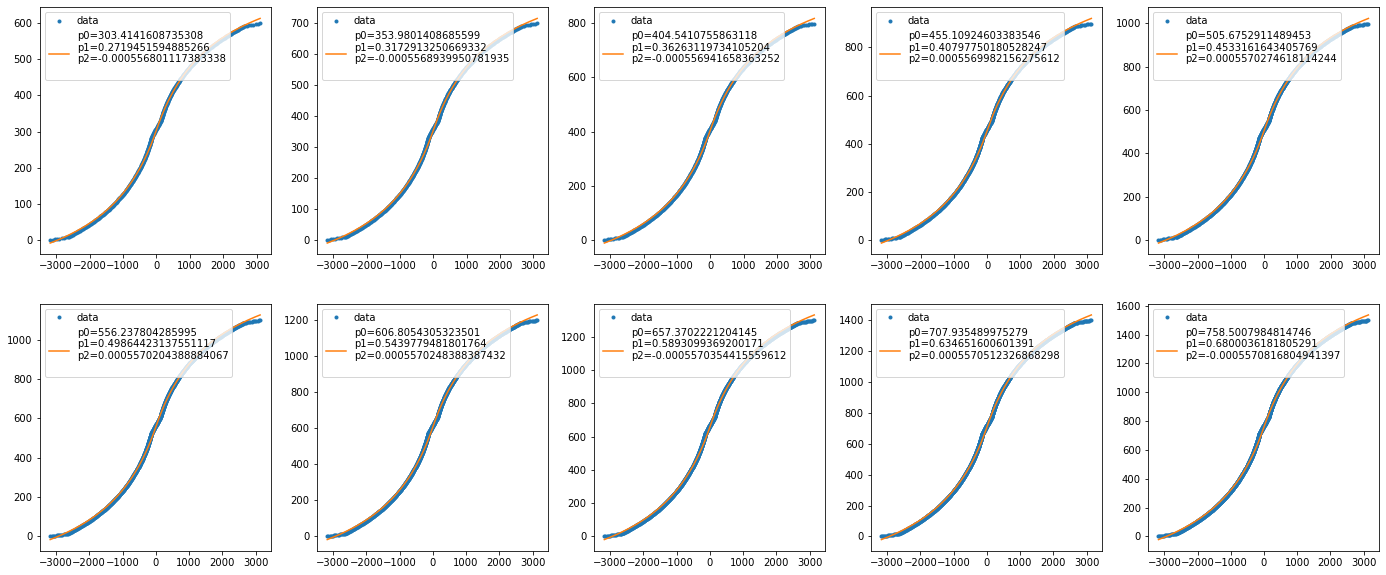

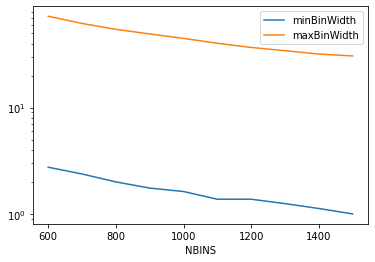

In [5]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


data = allHits.loc[(allHits['pc'].isin(xLayers)) & (allHits['x']<=3200) & (allHits['x']>=-3200)]['x']

urax = data.plot.hist(bins=25, title='Integrated SciFi Hit Distribution (X Layers)', figsize=(12,10), fontsize=20, edgecolor='black')
urax.set_xlabel('x [mm]', fontsize=24)
urax.set_ylabel('Count', fontsize=24)
urax.title.set_size(24)
#out_0,equal_bins_0 = pd.qcut(data, q=25, retbins=True)
#urax0 = data.plot.hist(bins=equal_bins_0, title='Integrated SciFi Hit Distribution (X Layers)', figsize=(12,10), fontsize=20, edgecolor='black')
#urax0.set_xlabel('x [mm]', fontsize=24)
#urax0.set_ylabel('Count', fontsize=24)
#urax0.title.set_size(24)
def fit3(x, p0, p1, p2, p3, p4, p5, p6, p7):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5 + p6 * x**6 + p7 * x**7

def fitFastSigmoid(x, p0, p1, p2 ):
    return p0 + p1 * x / (1 + abs(x * p2) ) 

def FastSigmoidInverse(y, p0, p1, p2):
    return (y - p0) / (p0 * p2 + p1 - p2 * y)#(p0 - y) / (p0 * p2 - p1 - p2 * y)

NBINS=[600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
SHIFTS = [1.1, 1.5, 1.8, 2.2, 5.5, 4.9, 3.2, 3.6, 3.9, 4.2]
minBinWidths = []
maxBinWidths = []
nBinsReal = []
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
for i, BINS in enumerate(NBINS):
    out,equal_bins = pd.qcut(data, q=BINS, retbins=True)
    binWidths = np.array([ abs(equal_bins[i] - equal_bins[i+1]) for i in range(len(equal_bins)-1)])
    minBinWidths.append( binWidths.min() )
    maxBinWidths.append( binWidths.max() )
    #equal_bincenters = np.array([0.5 * ( equal_bins[i] + equal_bins[i+1] ) for i in range(len(equal_bins)-1)] ) 
    popt, pcov = curve_fit( fitFastSigmoid, xdata=equal_bins[:-1], ydata=np.arange(0, BINS) )
    if i<5:
        axes[0,i].plot(equal_bins[:-1], np.arange(0, BINS), '.', label='data')
        axes[0,i].plot(equal_bins[:-1], fitFastSigmoid(equal_bins[:-1], *popt), label=f'p0={popt[0]}\np1={popt[1]}\np2={popt[2]}\n')
        axes[0,i].legend()
    else:
        axes[1,i-5].plot(equal_bins[:-1], np.arange(0, BINS), '.', label='data')
        axes[1,i-5].plot(equal_bins[:-1], fitFastSigmoid(equal_bins[:-1], *popt), label=f'p0={popt[0]}\np1={popt[1]}\np2={popt[2]}\n')
        axes[1,i-5].legend()
    nBinsReal.append(abs(int(fitFastSigmoid(-3000, popt[0], popt[1], popt[2])) - int(fitFastSigmoid(3000, popt[0], popt[1], popt[2]))))
    ###############33
    # SHIFT A BIT UPWARDS TO AVOID NEGATIVE INDICES p0+2.5
    ################################3#
    shift = SHIFTS[i]
    print(f'BINS={BINS}')
    print(f'shift={shift}')
    print(popt)
    print(f'at -3000 = {int(fitFastSigmoid(-3000., popt[0]+shift, popt[1], popt[2]))}')
    print(f'at 3000 = {int(fitFastSigmoid(3000., popt[0]+shift, popt[1], popt[2]))}')
    print(f'at -3000 = {fitFastSigmoid(-3000., popt[0]+shift, popt[1], popt[2])}')
    print(f'at 3000 = {fitFastSigmoid(3000., popt[0]+shift, popt[1], popt[2])}')
    #print(f'inv at 0 = {FastSigmoidInverse(506, popt[0]+shift, popt[1], popt[2])}')
    #print(f'inv at 1016 = {FastSigmoidInverse(1016, popt[0]+shift, popt[1], popt[2])}')
    print()
binData = pd.DataFrame({'NBINS':NBINS, 'nBinsReal': nBinsReal,'minBinWidth':minBinWidths, 'maxBinWidth':maxBinWidths})
ax = binData.plot(x='NBINS', y=['minBinWidth', 'maxBinWidth'], logy=True)
binData
#out,equal_bins = pd.qcut(data, q=1000, retbins=True)
#fig, axis = plt.subplots(figsize=(12,10))
#axis.set_title('Mapping Bin Number to x Position', fontsize=24)
#axis.plot(equal_bins[:-1], np.arange(0,1000), '.' )
#axis.set_xlabel('x [mm]', fontsize=24)
#axis.set_ylabel('Bin Number', fontsize=24)
#axis.tick_params(axis='both', which='major', labelsize=20)
#axis.tick_params(axis='both', which='minor', labelsize=16)
#popt, pcov = curve_fit( fitFastSigmoid, xdata=equal_bins[:-1], ydata=np.arange(0, 1000) )
#axis.plot(equal_bins[:-1], fitFastSigmoid(equal_bins[:-1], *popt), label=f'p0={popt[0]}\np1={popt[1]}\np2={popt[2]}\n', color='red', markersize=24)
#axis.legend(fontsize=20)